In [1]:
import json
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from PIL import Image
import numpy as np
from collections import Counter

importieren der Reden und anwenden der Lemmata

In [2]:
def laden_alleReden():
    
    with open('../data/speeches_preprocessed.json', 'r') as fp:
        data = json.load(fp)
    return data.copy()

In [3]:
alleReden = laden_alleReden()

Reden nach Parteien sortieren und zu Parteitexten zusammenfügen

In [4]:
reden_gefiltert = {'CDU/CSU':[],
                   'SPD':[],
                   'AfD':[],
                   'FDP':[],
                   'BÜNDNIS 90/DIE GRÜNEN':[],
                   'DIE LINKE':[],
                   'fraktionslos':[],
                   'Bremen':[]
                  }
for rede in alleReden:
    rede['party']=rede['party'].replace(u'\xa0', u' ')
    if rede['party']=='Bündnis 90/Die Grünen':
        rede['party']='BÜNDNIS 90/DIE GRÜNEN'
    if rede['party']=='Fraktionslos':
        rede['party']='fraktionslos'
    
    reden_gefiltert[ rede['party'] ].extend(rede['text_lem'])

Methode zum Erstellen von unique words von Einzelparteien und Parteipaaren

In [5]:
def return_unique_words(partylist,word_dict):

    andereworte = set()
    parteienworte = set()
    for key in word_dict.keys():
        if key not in partylist:
            andereworte = andereworte | set(word_dict[key])
        else:
            parteienworte = parteienworte | set(word_dict[key])
    
    #andereworte = set(andereworte)
    #parteienworte = set(parteienworte)
    

    unique_words = parteienworte - andereworte
    
    return unique_words

unique words Einzelpartei. Nachfolgend weiter bei Wordcounterliste für Einzelpartei

In [6]:
unique_words = return_unique_words(['AfD'],reden_gefiltert)

In [7]:
len(unique_words)

24337

unique words nach Parteien in Form von keys sortiert

In [8]:
uw_all = {'SPD': return_unique_words('SPD',reden_gefiltert),
'FDP': return_unique_words('FDP',reden_gefiltert),
'CDU/CSU': return_unique_words('CDU/CSU',reden_gefiltert),
'DIE LINKE': return_unique_words('DIE LINKE',reden_gefiltert),
'BÜNDNIS 90/DIE GRÜNEN': return_unique_words('BÜNDNIS 90/DIE GRÜNEN',reden_gefiltert),
'AfD': return_unique_words('AfD',reden_gefiltert)
}

shared unique words von Parteipaaren

In [ ]:
rows, cols = (len(uw_all), len(uw_all))
suw = [[0 for i in range(cols)] for j in range(rows)]
suw_words = [[0 for i in range(cols)] for j in range(rows)]
for ix,p1 in enumerate(uw_all.keys()):
    for jx,p2 in enumerate(uw_all.keys()):
        if jx > ix:
            print(p1,p2)
            tmp = return_unique_words([p1,p2],reden_gefiltert) - return_unique_words(p1,reden_gefiltert) - return_unique_words(p2,reden_gefiltert)
            suw_words[ix][jx] = tmp
            suw[ix][jx] = len(tmp)
            suw[jx][ix] = suw[ix][jx]
print(suw)
#0 SPD, 1 FDP, 2 CDU/CSU, 3 Linke, 4 Grüne, 5 AfD

In [ ]:
print(uw_all.keys())
#print(suw_words[0][1])
#suw

### Wordcounterliste und wordcloud für Einzelpartei

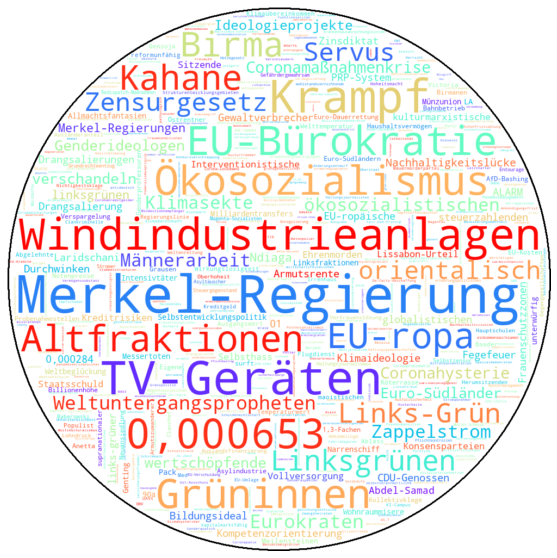

In [23]:
party = 'AfD'

uw_counter = [wort for wort in reden_gefiltert[party] if wort in uw_all[party]]
counts = Counter(uw_counter)

mask = np.array(Image.open("circle.png"))

wordcloud = WordCloud(width=3200, height=3200,background_color='white', max_words=500, mask=mask,contour_color='#000000',contour_width=3,colormap='rainbow').generate_from_frequencies(counts)
#wordcloud = WordCloud(background_color='white', max_words=100, mask=mask).generate_from_frequencies(counts)

# create image as circle

fig = plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
# store to file
#party='DIE GRÜNEN'
#plt.savefig(f"../private/wordclouds/wordcloud_{party}.png", format="png")
#plt.savefig("circle", format="png")
plt.show()


## Speichern als Raster Image

In [22]:
# store to file
party='DIE GRÜNEN'
wordcloud.to_file(f"../private/wordclouds/wordcloud_{party}.png")
#plt.savefig(f"../private/wordclouds/wordcloud_{party}.png", format="png")

### Speichern als SVG

In [12]:
party='DIE GRÜNEN'
wordcloud_svg = wordcloud.to_svg(embed_font=True)
f = open(f"../private/wordclouds/wordcloud_{party}.svg","w+")
f.write(wordcloud_svg)
f.close()

TypeError: write() argument must be str, not WordCloud

### Wordcounterliste und Cloud für Parteipaar

In [ ]:


uw_counter = [wort for wort in reden_gefiltert['SPD'] + reden_gefiltert['FDP'] if wort in suw_words[0][1]]

counts = Counter(uw_counter)

mask = np.array(Image.open("circle.png"))

wordcloud = WordCloud(background_color='white', max_words=500, mask=mask,contour_color='#000000',contour_width=3,colormap='rainbow').generate_from_frequencies(counts)
#wordcloud = WordCloud(background_color='white', max_words=100, mask=mask).generate_from_frequencies(counts)

# create image as circle

fig = plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
# store to file
#plt.savefig("circle", format="png")
plt.show()



Counter

### Speichern als SVG

In [ ]:
wordcloud_svg = wordcloud.to_svg(embed_font=True)
f = open("../private/wordclouds/wordcloud.svg","w+")
f.write(wordcloud_svg )
f.close()

construct graph

In [ ]:
nodes = []
for px,partei in enumerate(uw_all.keys()):
    node = {
        'id' : px,
        'name' : partei,
        'nuw' : len(uw_all[partei])
    }
    nodes.append(node)
    
nodes

In [ ]:
suw[0][1]

In [ ]:

graph = {
    'directed': False,
    'graph': 'word_graph',
    'links': [],
    'nodes': nodes
}    

for ix,nodeI in enumerate(graph['nodes']):
    for jx,nodeJ in enumerate(graph['nodes']):
        if jx > ix:
            #print(p1,p2)
            #tmp = return_unique_words([p1,p2],reden_gefiltert) - return_unique_words(p1,reden_gefiltert) - return_unique_words(p2,reden_gefiltert)
            #suw_words[ix][jx] = tmp
            weight = suw[ix][jx]
            #suw[jx][ix] = suw[ix][jx]
            
            source = nodeI['id']
            target = nodeJ['id']
            link_dict = {
                    'source':source,
                    'target':target,
                    'weight':weight       
                }
            graph['links'].append(link_dict)
    
print(graph)

Graph speichern

In [ ]:
import networkx as nx

graphforgephi = nx.Graph()
for node in graph['nodes']:
    graphforgephi.add_node(node['id'],name = node['name'],nuw = node['nuw']);
    #if(node['name'] == 'Angela Merkel'):
    #    print(node['tops'])

print('nodes done')
for link in (graph['links']):   
    graphforgephi.add_edge(link['source'],link['target'],weight = link['weight'])
print('links done')   
nx.write_gexf(graphforgephi, "graphforgephi.gexf")
print('save done')